#### Objective: Develop machine learning models that can predict whether a employee seek treatment or not. 
#### Database: This dataset is from a 2014 survey that measures attitudes towards mental health and frequency of mental health disorders in the tech workplace.

When employees receive treatment for depression, they are more likely to experience improved work performance and lower rates of absenteeism. This, in turn, can lead to increased productivity and retention for employers. Moreover, providing mental health benefits can help create a culture of understanding and compassion, which can contribute to employees feeling cared for and happy at work. Overall, investing in mental health benefits can be a good business decision that benefits both employees and employers.  

For data exploration, please see part1. github.com/johnpannyc/Mental-Health-in-Tech-Survey-Kaggle-/blob/main/Survey.ipynb

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import warnings
warnings.simplefilter('ignore')

In [2]:
import os
for dirname, _, filenames in os.walk(r'H:\Python Committee\Python Machine Learning Presentation\mental health survey'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

H:\Python Committee\Python Machine Learning Presentation\mental health survey\humanhead.png
H:\Python Committee\Python Machine Learning Presentation\mental health survey\images.jpg
H:\Python Committee\Python Machine Learning Presentation\mental health survey\survey.csv
H:\Python Committee\Python Machine Learning Presentation\mental health survey\Thumbs.db


In [63]:
# pip install --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host files.pythonhosted.org xgboost

In [4]:
df = pd.read_csv(r'H:\Python Committee\Python Machine Learning Presentation\mental health survey\survey.csv')

In [5]:
df.head(5).style.applymap(lambda x : "background-color: #CCCCFF")

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,nan,No,Yes,Often,6-25,No,Yes,Yes,Not sure,No,Yes,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,nan
1,2014-08-27 11:29:37,44,M,United States,IN,nan,No,No,Rarely,More than 1000,No,No,Don't know,No,Don't know,Don't know,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No,nan
2,2014-08-27 11:29:44,32,Male,Canada,nan,nan,No,No,Rarely,6-25,No,Yes,No,No,No,No,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,nan
3,2014-08-27 11:29:46,31,Male,United Kingdom,nan,nan,Yes,Yes,Often,26-100,No,Yes,No,Yes,No,No,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,nan
4,2014-08-27 11:30:22,31,Male,United States,TX,nan,No,No,Never,100-500,Yes,Yes,Yes,No,Don't know,Don't know,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,nan


The survey dataset includes information about mental health survey responses from people in different countries. Among all the countries, the majority of respondents are from the US, it may not be accurate to draw conclusions about mental health trends in other countries based on the data.  All the states are from US, so we can drop this column too.In addition, we drop the columns of timestamp and comments.  

It's important to note that removing columns can also impact the quality of our analysis, so we should carefully consider which columns are essential for our research goals before dropping any data.

In [6]:
df = df.drop(['Country','state','Timestamp','comments'], axis = 1)

Re-group the gender value:  
(1). (Male, or cis Male) = 'Male'; (2). (Female, or cis Female) = 'Female'; (3). Else: 'Other'

In [7]:
def standardize_gender(df):
    gender_list = df['Gender'].tolist()
    standardized_list = []
    
    for gender in gender_list:
        if gender in ['Male ', 'male', 'M', 'm', 'Male', 'Cis Male',
                      'Man', 'cis male', 'Mail', 'Male-ish', 'Male (CIS)',
                      'Cis Man', 'msle', 'Malr', 'Mal', 'maile', 'Make']:
            standardized_list.append('Male')
        elif gender in ['Female ', 'female', 'F', 'f', 'Woman', 'Female',
                        'femail', 'Cis Female', 'cis-female/femme', 'Femake', 'Female (cis)',
                        'woman']:
            standardized_list.append('Female')
        else:
            standardized_list.append('Other')
    
    df['Gender'] = standardized_list
    
    return df

In [8]:
my_modified_df = standardize_gender(df)

In [9]:
df['Gender'].value_counts().reset_index().style.applymap(lambda x : "background-color: #40E0D0")

,index,Gender
0,Male,991
1,Female,247
2,Other,21


In [10]:
# Correct the outliers
# Let us treat age
df.loc[df.Age<12,'Age']=15
df.loc[df.Age>75,'Age']=75

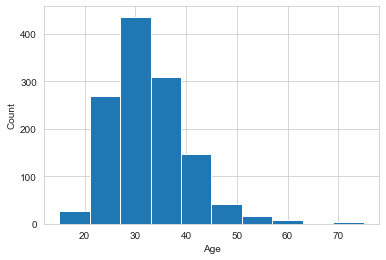

In [11]:
# create a histogram of the 'Age' column in the 'df' DataFrame
df['Age'].hist()
# set the x-label
plt.xlabel('Age')
# set the y-label
plt.ylabel('Count')
# display the histogram
plt.show()

In [12]:
df.dtypes

Age                           int64
Gender                       object
self_employed                object
family_history               object
treatment                    object
work_interfere               object
no_employees                 object
remote_work                  object
tech_company                 object
benefits                     object
care_options                 object
wellness_program             object
seek_help                    object
anonymity                    object
leave                        object
mental_health_consequence    object
phys_health_consequence      object
coworkers                    object
supervisor                   object
mental_health_interview      object
phys_health_interview        object
mental_vs_physical           object
obs_consequence              object
dtype: object

In [13]:
df.isna().sum()

Age                            0
Gender                         0
self_employed                 18
family_history                 0
treatment                      0
work_interfere               264
no_employees                   0
remote_work                    0
tech_company                   0
benefits                       0
care_options                   0
wellness_program               0
seek_help                      0
anonymity                      0
leave                          0
mental_health_consequence      0
phys_health_consequence        0
coworkers                      0
supervisor                     0
mental_health_interview        0
phys_health_interview          0
mental_vs_physical             0
obs_consequence                0
dtype: int64

In [14]:
#replacing NaN values because they are so few
df['self_employed'] = df['self_employed'].fillna('Don\'t know')
df['work_interfere'] = df['work_interfere'].fillna('Don\'t know' )

In [15]:
self_employed = pd.DataFrame(df['self_employed'].value_counts())
self_employed.style.applymap(lambda x : "background-color: #90EE90")

,self_employed
No,1095
Yes,146
Don't know,18


In [16]:
work_interfere = pd.DataFrame(df['work_interfere'].value_counts())
work_interfere.style.applymap(lambda x : "background-color: #40E0D0")

,work_interfere
Sometimes,465
Don't know,264
Never,213
Rarely,173
Often,144


##### Encoding conserving the ordinal information.

In [17]:
list_col=[ 'Gender', 'self_employed', 'family_history', 'treatment',
       'work_interfere', 'no_employees', 'remote_work', 'tech_company',
       'benefits', 'care_options', 'wellness_program', 'seek_help',
       'anonymity', 'leave', 'mental_health_consequence',
       'phys_health_consequence', 'coworkers', 'supervisor',
       'mental_health_interview', 'phys_health_interview',
       'mental_vs_physical', 'obs_consequence']

for col in list_col: 
    print('{} :{} ' . format(col.upper(),df[col].unique()))

GENDER :['Female' 'Male' 'Other'] 
SELF_EMPLOYED :["Don't know" 'Yes' 'No'] 
FAMILY_HISTORY :['No' 'Yes'] 
TREATMENT :['Yes' 'No'] 
WORK_INTERFERE :['Often' 'Rarely' 'Never' 'Sometimes' "Don't know"] 
NO_EMPLOYEES :['6-25' 'More than 1000' '26-100' '100-500' '1-5' '500-1000'] 
REMOTE_WORK :['No' 'Yes'] 
TECH_COMPANY :['Yes' 'No'] 
BENEFITS :['Yes' "Don't know" 'No'] 
CARE_OPTIONS :['Not sure' 'No' 'Yes'] 
WELLNESS_PROGRAM :['No' "Don't know" 'Yes'] 
SEEK_HELP :['Yes' "Don't know" 'No'] 
ANONYMITY :['Yes' "Don't know" 'No'] 
LEAVE :['Somewhat easy' "Don't know" 'Somewhat difficult' 'Very difficult'
 'Very easy'] 
MENTAL_HEALTH_CONSEQUENCE :['No' 'Maybe' 'Yes'] 
PHYS_HEALTH_CONSEQUENCE :['No' 'Yes' 'Maybe'] 
COWORKERS :['Some of them' 'No' 'Yes'] 
SUPERVISOR :['Yes' 'No' 'Some of them'] 
MENTAL_HEALTH_INTERVIEW :['No' 'Yes' 'Maybe'] 
PHYS_HEALTH_INTERVIEW :['Maybe' 'No' 'Yes'] 
MENTAL_VS_PHYSICAL :['Yes' "Don't know" 'No'] 
OBS_CONSEQUENCE :['No' 'Yes'] 


In [18]:
# Label Encoding the categorical variables

from sklearn.preprocessing import LabelEncoder
object_cols = [ 'Gender','self_employed', 'family_history', 'treatment',
       'work_interfere', 'no_employees', 'remote_work', 'tech_company',
       'benefits', 'care_options', 'wellness_program', 'seek_help',
       'anonymity', 'leave', 'mental_health_consequence',
       'phys_health_consequence', 'coworkers', 'supervisor',
       'mental_health_interview', 'phys_health_interview',
       'mental_vs_physical', 'obs_consequence']
label_encoder = LabelEncoder()
for col in object_cols:
    label_encoder.fit(df[col])
    df[col] = label_encoder.transform(df[col])

In [19]:
df.sample(5).style.applymap(lambda x : "background-color: #90EE90")

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
374,21,0,1,1,1,3,2,0,1,0,1,0,1,0,2,2,1,1,0,1,2,0,0
1240,31,1,1,1,1,4,1,0,1,0,0,1,1,2,2,1,1,1,0,1,1,0,0
1212,34,0,1,0,1,4,5,0,0,1,2,1,2,2,1,0,0,1,2,1,0,1,1
1199,25,1,1,0,0,0,1,0,1,0,1,1,0,0,0,0,1,1,2,1,1,0,0
495,23,0,1,1,1,2,5,0,1,2,1,0,1,0,0,0,1,1,1,1,1,2,1


In [20]:
features = list(df.columns)

In [21]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
df[features] = std_scaler.fit_transform(df)

In [22]:
df.sample(5).style.applymap(lambda x : "background-color: #90EE90")

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
330,-1.067522,0.422348,-0.293581,-0.800912,-1.011986,-1.435312,-0.450208,-0.652550,0.470260,1.129776,0.052329,1.683693,1.574830,1.490132,1.717185,0.191430,0.345935,0.044835,-0.115744,0.302976,-0.992534,1.420803,-0.413718
358,0.256365,0.422348,-0.293581,-0.800912,0.988156,1.074490,-1.025067,1.532450,0.470260,-0.065508,-1.103493,-0.056676,0.129705,-0.713128,0.390844,1.494192,2.400335,0.044835,-0.115744,0.302976,-0.992534,-0.977040,-0.413718
93,-1.861855,2.775163,-0.293581,-0.800912,-1.011986,-1.435312,-0.450208,1.532450,0.470260,1.129776,1.208150,-0.056676,0.129705,1.490132,0.390844,0.191430,0.345935,1.657626,1.068989,2.643141,1.772069,-0.977040,-0.413718
155,-0.935134,0.422348,-0.293581,1.248576,0.988156,1.074490,-0.450208,-0.652550,-2.126483,-1.260792,-1.103493,-0.056676,-1.315420,-0.713128,-0.272327,-1.111331,0.345935,0.044835,-0.115744,0.302976,-0.992534,0.221881,-0.413718
299,0.653531,0.422348,-0.293581,-0.800912,-1.011986,-0.807861,1.274371,-0.652550,0.470260,1.129776,1.208150,1.683693,1.574830,-0.713128,-0.935497,0.191430,0.345935,0.044835,1.068989,-2.037189,-0.992534,-0.977040,-0.413718


In [23]:
# We should not perform eda on test data as it will cloud your decision of model selections and hyperparameters.
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(df,test_size=0.1,stratify=df['treatment'],random_state=42 )

In [24]:
print(f'Train_data Dimensions : {train_data.shape}\nTest data dimension : {test_data.shape}')

Train_data Dimensions : (1133, 23)
Test data dimension : (126, 23)


In [25]:
# Train Test Split
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(df,test_size=0.2,stratify=df['treatment'],random_state=42 )

In [26]:
print(f'train data Dimensions : {train_data.shape}\ntest data dimension : {test_data.shape}')

train data Dimensions : (1007, 23)
test data dimension : (252, 23)


In [27]:
# Let us divide training set into independent and dependent variables
X_train = train_data.drop('treatment',axis=1)
y_train = train_data['treatment'].copy()

In [28]:
features = list(X_train.columns)

In [29]:
X_train.head().style.applymap(lambda x : "background-color: #90EE90")

,Age,Gender,self_employed,family_history,work_interfere,no_employees,remote_work,tech_company,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
1149,-0.008412,0.422348,-0.293581,-0.800912,0.447040,0.699511,-0.652550,0.470260,1.129776,0.052329,-0.056676,-1.315420,-0.713128,-0.935497,-1.111331,0.345935,-1.567956,-0.115744,0.302976,-0.992534,-0.977040,-0.413718
909,2.109808,0.422348,-0.293581,-0.800912,-0.807861,1.274371,-0.652550,0.470260,1.129776,1.208150,1.683693,1.574830,1.490132,-0.935497,-1.111331,-1.708464,1.657626,1.068989,0.302976,-0.992534,1.420803,2.417104
1011,0.123976,-1.930467,2.594064,-0.800912,-0.807861,-1.599926,1.532450,0.470260,-0.065508,1.208150,-1.797045,-1.315420,1.490132,0.390844,-1.111331,0.345935,-1.567956,-0.115744,0.302976,0.389767,1.420803,-0.413718
827,1.050698,0.422348,2.594064,-0.800912,1.074490,-1.599926,1.532450,0.470260,-1.260792,0.052329,-0.056676,0.129705,-0.713128,0.390844,1.494192,-1.708464,0.044835,-1.300478,0.302976,0.389767,-0.977040,-0.413718
62,-0.670356,0.422348,-0.293581,-0.800912,-0.807861,-1.025067,-0.652550,0.470260,1.129776,0.052329,-0.056676,1.574830,-0.713128,0.390844,0.191430,0.345935,1.657626,1.068989,-2.037189,-0.992534,1.420803,-0.413718


In [30]:
def train_evaluate(model,X_train,y_train,name):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_train)
    f1_train = f1_score(y_train,y_pred)

    #Cross validation
    f1_val = cross_val_score(model,X_train,y_train,scoring='f1',cv=10)
    
    # returning the scores
    score = pd.DataFrame({'Name' : name ,'F1_score_trainset' : [f1_train], 'F1_score_validationset' : [f1_val.mean()]})
    return score

In [31]:
from sklearn.preprocessing import LabelEncoder
lb_encoder = LabelEncoder()
y_train = lb_encoder.fit_transform(y_train)

The F1 score of the training set is the F1 score calculated on the data that was used to train the model. This metric tells you how well the model fits the training data.

Cross-validation is a technique used in machine learning to evaluate the performance of a model on unseen data. The goal of cross-validation is to estimate how well a model will generalize to new data that it has not seen during training.

The F1 score of the validation set is the F1 score calculated on data that the model has not seen during training. This metric tells you how well the model generalizes to new, unseen data.

Ideally, you want the F1 score of both the training set and validation set to be high. A high F1 score on the training set indicates that the model fits the training data well, while a high F1 score on the validation set indicates that the model generalizes well to new data. If the F1 score on the training set is high but the F1 score on the validation set is low, it is a sign of overfitting. Overfitting means that the model has memorized the training data too well, and it is not able to generalize to new data. In this case, you may want to consider adjusting the hyperparameters of your model or using regularization techniques to prevent overfitting.

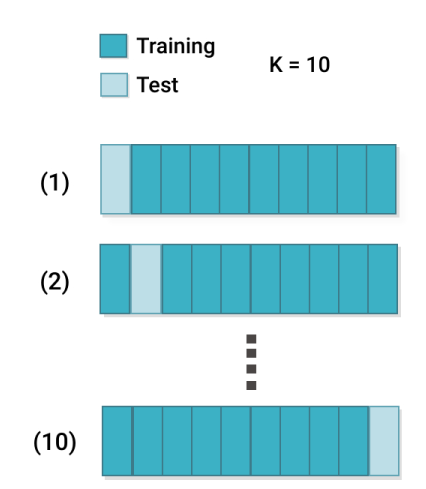

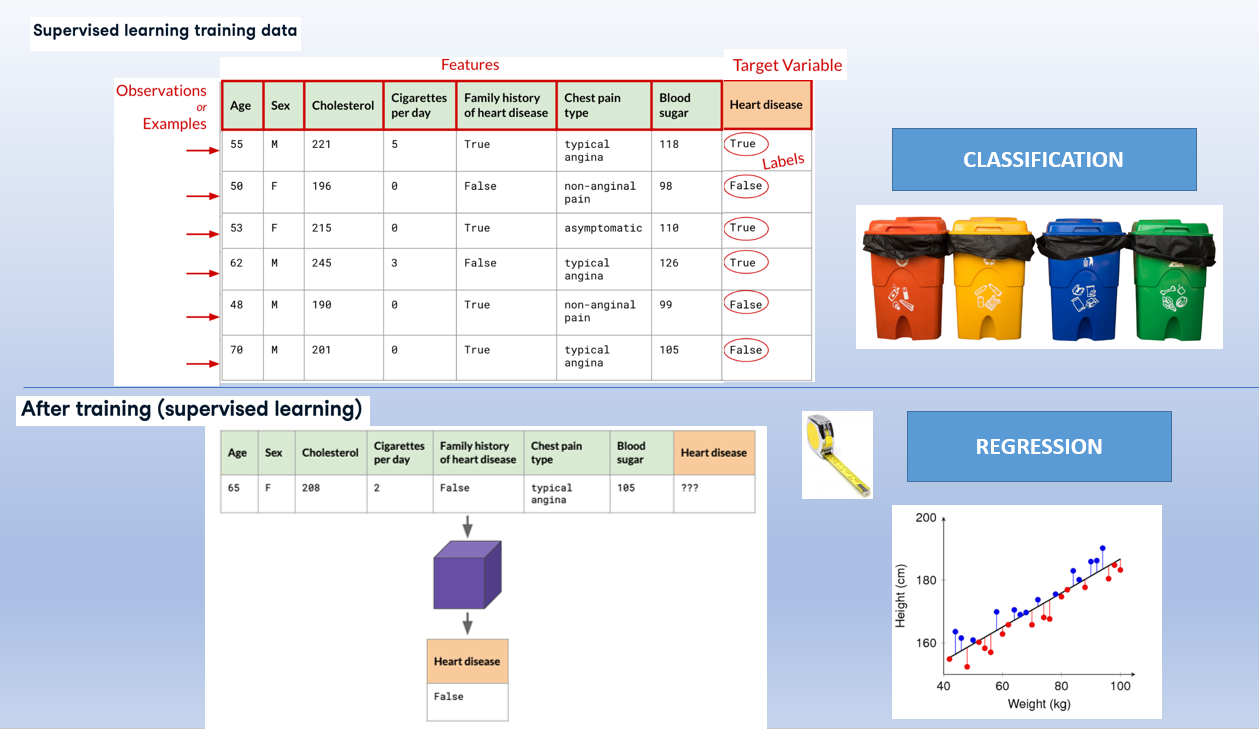

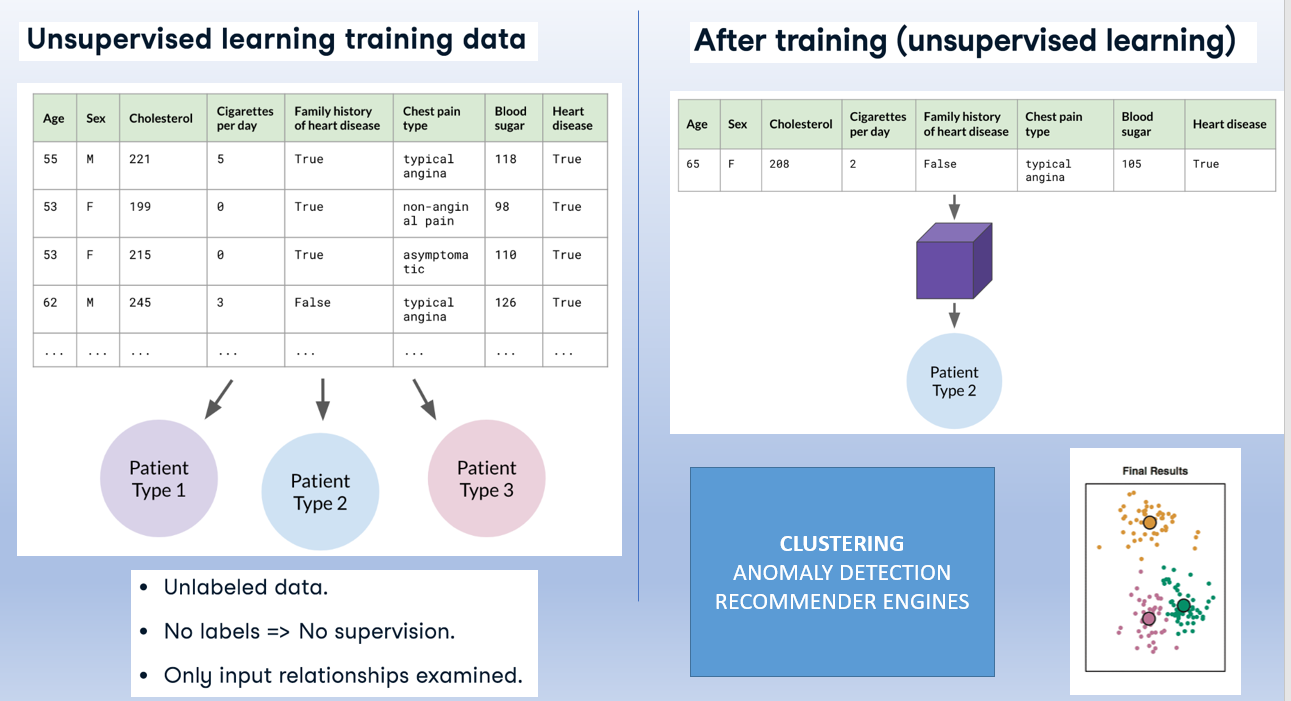

In [32]:
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

In [33]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(penalty='l1',solver='liblinear')
train_evaluate(log_reg,X_train,y_train,'Logistic Regression').style.applymap(lambda x : "background-color: #90EE90")

,Name,F1_score_trainset,F1_score_validationset
0,Logistic Regression,0.832227,0.814691


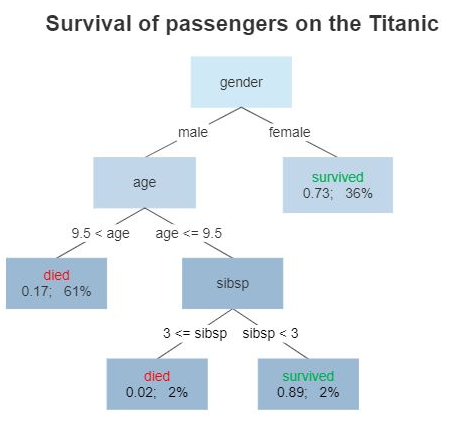
A tree showing survival of passengers on the Titanic ("sibsp" is the number of spouses or siblings aboard). The figures under the leaves show the probability of survival and the percentage of observations in the leaf. Summarizing: Your chances of survival were good if you were (i) a female or (ii) a male at most 9.5 years old with strictly fewer than 3 siblings.

In [34]:
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(max_leaf_nodes=4,random_state=42)
train_evaluate(dt_clf,X_train,y_train,'DecisionTreeClassifier').style.applymap(lambda x : "background-color: #90EE90")

,Name,F1_score_trainset,F1_score_validationset
0,DecisionTreeClassifier,0.848858,0.849236


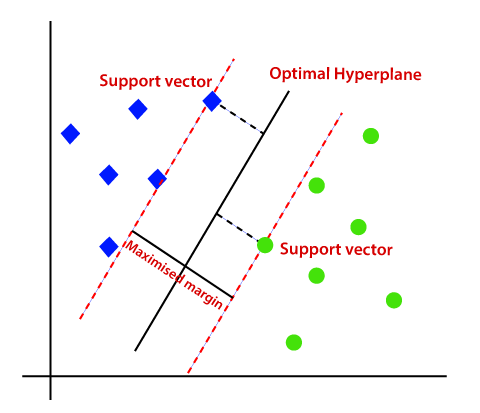
Support Vector Machine (SVM) is a popular supervised machine learning algorithm used for classification and regression analysis. In this explanation, I will focus on SVM for classification.

The basic idea behind SVM is to find the hyperplane that maximally separates the different classes in the feature space. A hyperplane is a decision boundary that separates the data into different regions based on their class labels. In SVM, the hyperplane is chosen in such a way that it maximizes the margin between the two closest data points from different classes.

In [35]:
from sklearn.svm import SVC
svc_clf = SVC()
train_evaluate(svc_clf,X_train,y_train,'Support Vector Classifier').style.applymap(lambda x : "background-color: #90EE90")

,Name,F1_score_trainset,F1_score_validationset
0,Support Vector Classifier,0.890538,0.828428


Random forest is a type of ensemble learning model that combines multiple decision trees to make predictions. Each tree in the forest is trained on a randomly sampled subset of the data and a randomly selected subset of the features, which helps to reduce overfitting and improve the model's generalization ability. The final prediction is made by taking the majority vote of all the trees in the forest.

In [36]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(random_state=42)
train_evaluate(rnd_clf,X_train,y_train,'RandomForestClassifier').style.applymap(lambda x : "background-color: #90EE90")

,Name,F1_score_trainset,F1_score_validationset
0,RandomForestClassifier,1.000000,0.839829


Adaboost (Adaptive Boosting) is a popular ensemble learning method that combines multiple weak learners (classifiers that perform slightly better than random guessing) into a strong learner. The algorithm works by assigning higher weights to the misclassified instances in each iteration, so that subsequent weak learners focus on the difficult instances. In each iteration, a new weak learner is trained on a weighted sample of the data, and the final prediction is made by taking a weighted combination of all the weak learners. Adaboost is known for its ability to handle high-dimensional data and noisy datasets, and it has been used in various applications, such as face detection and speech recognition.

In [37]:
from sklearn.ensemble import AdaBoostClassifier
dt_clf_ada = DecisionTreeClassifier()
Ada_clf = AdaBoostClassifier(base_estimator=dt_clf_ada,random_state=42)
train_evaluate(Ada_clf,X_train,y_train,"ADA BOOST CLASSIFIER").style.applymap(lambda x : "background-color: #90EE90")

,Name,F1_score_trainset,F1_score_validationset
0,ADA BOOST CLASSIFIER,1.000000,0.728755


Gradient Boosting is a powerful ensemble learning method that combines multiple decision trees to create a predictive model. Unlike traditional Adaboost which focuses on sample weights, Gradient Boosting focuses on gradient descent optimization to minimize a cost function. In Gradient Boosting, each new decision tree is trained to correct the errors of the previous tree. The algorithm iteratively fits weak learners to the residuals of the previous model, with each new model improving on the errors of the previous ones. This process continues until a stopping criterion is met or until the model reaches a pre-determined number of trees. Gradient Boosting is a powerful and flexible method that can be used for both regression and classification problems, and it is known for its high predictive accuracy and robustness to outliers.

In [38]:
from sklearn.ensemble import GradientBoostingClassifier
gdb_clf = GradientBoostingClassifier(random_state=42,subsample=0.8)
train_evaluate(gdb_clf,X_train,y_train,"GradientBoosting CLASSIFIER").style.applymap(lambda x : "background-color: #90EE90")

,Name,F1_score_trainset,F1_score_validationset
0,GradientBoosting CLASSIFIER,0.900763,0.825121


XGBoost (Extreme Gradient Boosting) is an optimized implementation of the gradient boosting algorithm that is designed to be highly efficient, scalable and accurate. It uses a number of advanced features, such as tree pruning, cache-aware access, and parallelization, to improve the performance and scalability of the model. XGBoost also includes regularization techniques to prevent overfitting and a flexible framework that supports both regression and classification problems. Additionally, it includes built-in support for missing values and user-defined objective functions. XGBoost has become a popular choice in machine learning competitions and is widely used in a variety of applications such as click-through rate prediction and image classification.

In [41]:
from xgboost import XGBClassifier
xgb_clf = XGBClassifier(verbosity=0)
train_evaluate(xgb_clf,X_train,y_train,"XG Boost CLASSIFIER").style.applymap(lambda x : "background-color: #90EE90")

,Name,F1_score_trainset,F1_score_validationset
0,XG Boost CLASSIFIER,1.000000,0.833199


The purpose of fine-tuning is to optimize the performance of a pre-trained machine learning model on a specific task or domain by adjusting its parameters or architecture. Fine-tuning is typically done by training the pre-trained model on a new dataset with a small learning rate, while keeping some of the pre-trained weights frozen to prevent overfitting. This allows the model to adapt to the new task while still benefiting from the knowledge it has learned from the pre-training phase. Fine-tuning can help to improve the accuracy of a model and reduce the amount of data required for training, and it is commonly used in transfer learning and domain adaptation tasks, where the goal is to leverage the knowledge of a pre-trained model to improve the performance on a new task or domain.

In [42]:
# Fine Tuning Support Vector Classifier
from sklearn.model_selection import GridSearchCV
param_distribs = {
        'kernel': ['linear', 'rbf','polynomial'],
        'C': [0.01,0.01,0.1,0.15,0.2,0.25,0.5,0.75,1,2,10,100],
        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    }
svm_clf = SVC()
grid_cv = GridSearchCV(svm_clf , param_grid = param_distribs,
                              cv=5,scoring='f1',
                              verbose=1)
grid_cv.fit(X_train,y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 900 out of 900 | elapsed:   53.5s finished


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.01, 0.01, 0.1, 0.15, 0.2, 0.25, 0.5, 0.75, 1,
                               2, 10, 100],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['linear', 'rbf', 'polynomial']},
             scoring='f1', verbose=1)

In [43]:
grid_cv.best_estimator_

SVC(C=0.15, gamma=0.01)

In [44]:
train_evaluate(grid_cv.best_estimator_,X_train,y_train,"SVC Tuned").style.applymap(lambda x : "background-color: #90EE90")

,Name,F1_score_trainset,F1_score_validationset
0,SVC Tuned,0.835629,0.830051


In [45]:
# Fine Tuning Random Forest Classifier
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators':[3,10,30,50,100],'max_features':[2,4,6,8],'max_depth' : [1,2,3,4]}
]



forest_clf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(forest_clf, param_grid, cv=5,
                           scoring='f1',
                           return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid=[{'max_depth': [1, 2, 3, 4],
                          'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30, 50, 100]}],
             return_train_score=True, scoring='f1')

In [46]:
grid_search.best_estimator_

RandomForestClassifier(max_depth=4, max_features=4, random_state=42)

In [47]:
train_evaluate(grid_search.best_estimator_,X_train,y_train,"RandomForest Tuned").style.applymap(lambda x : "background-color: #90EE90")

,Name,F1_score_trainset,F1_score_validationset
0,RandomForest Tuned,0.850492,0.841377


In [48]:
# Fine Tuning GradientBoost Classifier
param_grid = [
    {'n_estimators':[3,10,30,50,100],
    'max_features':[2,4,6,8,10],
    'max_depth' : [1,2,3,4],
    'subsample': [0.25,0.5,0.75]}
]

gdb_clf2 = GradientBoostingClassifier(random_state=42)
grid_search2 = GridSearchCV(gdb_clf2, param_grid, cv=5,
                           scoring='f1',
                           return_train_score=True)
grid_search2.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             param_grid=[{'max_depth': [1, 2, 3, 4],
                          'max_features': [2, 4, 6, 8, 10],
                          'n_estimators': [3, 10, 30, 50, 100],
                          'subsample': [0.25, 0.5, 0.75]}],
             return_train_score=True, scoring='f1')

In [49]:
grid_search2.best_estimator_

GradientBoostingClassifier(max_depth=1, max_features=10, n_estimators=10,
                           random_state=42, subsample=0.25)

In [50]:
train_evaluate(grid_search2.best_estimator_,X_train,y_train,"GradientBoosting Tuned").style.applymap(lambda x : "background-color: #90EE90")

,Name,F1_score_trainset,F1_score_validationset
0,GradientBoosting Tuned,0.848858,0.849236


In [51]:
param_grid = [
    {'n_estimators':[3,10,30,50,100],
    'eta' : [0.01,0.025, 0.05, 0.1],
    'max_features':[2,4,6,8],
    'max_depth' : [1,2,3,4],
    'subsample': [0.5,0.75],
    'booster':['gblinear','gbtree']}
]

xgb_clf = XGBClassifier(verbosity = 0)
grid_search3 = GridSearchCV(xgb_clf, param_grid, cv=10,
                           scoring='f1',
                           return_train_score=True)
grid_search3.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                         

In [52]:
grid_search3.best_estimator_

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_features=2, max_leaves=None, min_child_weight=None,
              missing=nan, monotone_constraints=None, n_estimators=30,
              n_jobs=None, num_parallel_tree=None, ...)

In [53]:
train_evaluate(grid_search3.best_estimator_,X_train,y_train,"XGBoost Finetuned").style.applymap(lambda x : "background-color: #90EE90")

,Name,F1_score_trainset,F1_score_validationset
0,XGBoost Finetuned,0.848858,0.849872


In [54]:
XGBoost_final = grid_search3.best_estimator_

In [55]:
scores = pd.DataFrame({'Train_score' : [0.8489,0.8517,0.8566,0.8601],'Val_score' : [0.8428,0.8508,0.8527,0.8563]} 
                        ,index=['SVM','RandomForest','GDBoost','XGBoost'])
scores.style.applymap(lambda x : "background-color: #90EE90")

,Train_score,Val_score
SVM,0.848900,0.842800
RandomForest,0.851700,0.850800
GDBoost,0.856600,0.852700
XGBoost,0.860100,0.856300


#### After finetuning, XGboost is generalizing well on our dataset. So XGBoost will be my selected model.

In [56]:
test_data.shape

(252, 23)

In [57]:
# Repeating the preprocessing steps for the test data
X_test = test_data.drop('treatment',axis=1)
y_test = test_data['treatment'].copy()

In [58]:
# Encoding the target column
y_test = lb_encoder.transform(y_test)

In [59]:
# Evaluating the model on test set with our finalized model
y_test_pred = XGBoost_final.predict(X_test)
print(f'F1_score on Test Set : {f1_score(y_test,y_test_pred)}')

F1_score on Test Set : 0.8540925266903915


#### Finally, we developed a XGBoost_model which can predict whether an employee will seek mental health treament or not

In [60]:
XGBoost_final.feature_importances_

array([0.0265857 , 0.06880758, 0.        , 0.09734409, 0.36744586,
       0.07083151, 0.        , 0.        , 0.06624673, 0.07383436,
       0.        , 0.03608237, 0.07148156, 0.        , 0.        ,
       0.01817513, 0.02237102, 0.03205844, 0.        , 0.        ,
       0.        , 0.04873563], dtype=float32)

In [61]:
# Identify the key features that lead to mental health problems in tech space
data = {'feature_names':features,'feature_importance': XGBoost_final.feature_importances_}
featureimp_df = pd.DataFrame(data)
featureimp_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

Text(0.5, 1.0, 'Key Features')

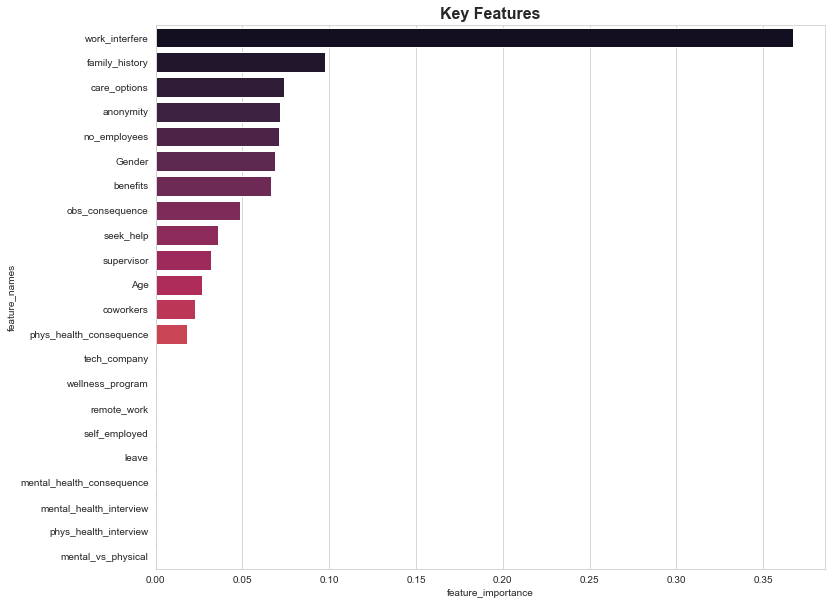

In [62]:
# I have found this method from stackoverflow for plotting feature importance easily
plt.figure(figsize=(12,10))
sns.barplot(data = featureimp_df, x = 'feature_importance' , y = 'feature_names' , palette='rocket')
plt.title("Key Features", fontsize=16, fontweight="bold")

In [159]:
df.sample(3)

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
884,35,1,1,1,1,4,2,1,1,2,2,1,0,0,0,0,0,1,0,1,0,1,0
1101,26,1,1,1,0,4,1,0,1,0,1,1,1,0,0,0,1,1,0,1,0,0,0
580,41,1,1,1,1,2,5,0,1,2,0,1,1,0,0,0,0,1,1,1,1,0,1


In [ ]:
from sklearn.model_selection import train_test_split
X = df.drop('treatment', axis = 1)
y = df['treatment']

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                   stratify = y,
                                                    test_size = 0.3,
                                                   random_state = 101)